In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.model_selection import KFold

In [2]:
# read the csv file
df = pd.read_csv('dataset.csv')
print(df.shape)

# remove non-numeric values from columns
for column in df.columns:
    df = df[pd.to_numeric(df[column], errors='coerce').notnull()]

# drop the fields with 'NA' values
df.dropna(axis = 0, inplace=True)

# reset the index
df.reset_index(drop=True, inplace=True)

# scale numerical variables to have zero mean and unit variance
scaler = StandardScaler()
df.iloc[:,0:-1] = scaler.fit_transform(df.iloc[:,0:-1].to_numpy())

print(df)
print(df.shape)


(766, 8)
           f1        f2        f3        f4        f5        f6        f7  \
0    0.644092  0.844637  0.148213  0.908737 -0.694636  0.202839  0.463021   
1   -0.842876 -1.123976 -0.160536  0.532503 -0.694636 -0.683852 -0.368158   
2    1.238879  1.938311 -0.263452 -1.285961 -0.694636 -1.101863  0.598540   
3   -0.842876 -0.998985 -0.160536  0.156269  0.119179 -0.493847 -0.922278   
4   -1.140270  0.500911 -1.498446  0.908737  0.759842  1.406204  5.465156   
..        ...       ...       ...       ...       ...       ...       ...   
755 -0.842876  0.219680  0.971542  1.159559  0.257700  0.570182  1.757975   
756  0.941485  0.500911  1.074458  1.284971 -0.694636  0.000167 -0.247698   
757 -1.140270  0.063441  0.148213 -1.285961 -0.694636  0.544848 -0.648230   
758 -0.842876 -0.467772  0.354045 -1.285961 -0.694636  0.696852 -0.831932   
759  0.644092  2.157046  1.177375 -1.285961 -0.694636  0.443512 -0.587999   

     target  
0         1  
1         0  
2         1  
3         

C:\Users\Sankalp\AppData\Local\Temp\ipykernel_17808\2762403168.py:17: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,0:-1] = scaler.fit_transform(df.iloc[:,0:-1].to_numpy())


In [3]:
# set the input dataframe and the target
X_data = df.drop(['target'], axis=1)
Y_target = df['target']

# convert to pytorch tensors
X_data_tensor = torch.tensor(X_data.values, dtype=torch.float)
Y_target_tensor = torch.tensor(Y_target.values, dtype=torch.long)

# split the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data_tensor, Y_target_tensor, train_size=0.8, test_size=0.2, random_state=42)

# check the shapes
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([608, 7])
torch.Size([608])
torch.Size([152, 7])
torch.Size([152])


In [3]:
# check if GPU (cuda device) can be used
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


: 

In [9]:
# take the number of neurons equal to the number of features in the data
input_size = X_data.shape[1]     # 7  
hidden1_size = 64
hidden2_size = 64

hidden_size = 32
num_classes = 2


class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # hidden layer 1 with ReLU activation function
            nn.Linear(input_size, hidden1_size),
            nn.ReLU(),

            # hidden layer 2 with ReLU activation function
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            
            # output layer
            nn.Linear(hidden2_size, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

# observation: increasing the number of layers was causing overfitting and variance in the output.

model = NeuralNetwork(input_size, hidden1_size, hidden2_size, num_classes).to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [12]:
#  ==================================================     Training     ==================================================

batch_size = 64         # can use 128 too, since we are utilizing the GPU (cuda device)
num_epochs = 100
learning_rate = 0.0001
train_accuracies, test_accuracies = [], []

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))          # the testing set has a single batch


print(f"\nEpochs: {num_epochs}")

print(f"\ntrain batch size: {batch_size}")
print(f"number of batches: {len(train_loader)}")

print(f"\ntrain batch size: {len(test_data.tensors[0])}")
print(f"number of batches: {len(test_loader)}")


# choose the optimizer and loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)


# print("Training data batches:")
# for X, y in train_loader:
#     print(X.shape, y.shape)
    
# print("\nTest data batches:")
# for X, y in test_loader:
#     print(X.shape, y.shape)


for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.cuda()
        targets = targets.cuda()

        preds = model(data)
        pred_labels = torch.argmax(preds, axis=1)

        loss = loss_fn(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracies.append(
            100 * torch.mean((pred_labels == targets).float()).item()
        )

        # Test set
        X, y = next(iter(test_loader))
        X = X.cuda()
        y = y.cuda()
        pred_labels = torch.argmax(model(X), axis=1)
        test_accuracies.append(
            100 * torch.mean((pred_labels == y).float()).item()
        )


print(f"\ntrain_accuracies: {train_accuracies}")
print(f"train_accuracies: {len(train_accuracies)}")
print(f"Max accuracy: {max(train_accuracies)}")


print(f"\ntest_accuracies: {test_accuracies}")
print(f"test_accuracies: {len(test_accuracies)}")
print(f"Max accuracy: {max(test_accuracies)}")



Epochs: 100

train batch size: 64
number of batches: 10

train batch size: 152
number of batches: 1

train_accuracies: [79.6875, 78.125, 79.6875, 71.875, 79.6875, 79.6875, 75.0, 82.8125, 75.0, 75.0, 81.25, 78.125, 73.4375, 65.625, 84.375, 82.8125, 79.6875, 82.8125, 76.5625, 68.75, 78.125, 82.8125, 78.125, 73.4375, 82.8125, 76.5625, 81.25, 82.8125, 68.75, 68.75, 73.4375, 75.0, 71.875, 73.4375, 89.0625, 78.125, 79.6875, 78.125, 82.8125, 75.0, 73.4375, 76.5625, 79.6875, 81.25, 67.1875, 84.375, 76.5625, 78.125, 82.8125, 78.125, 78.125, 71.875, 84.375, 67.1875, 76.5625, 76.5625, 75.0, 84.375, 84.375, 81.25, 75.0, 73.4375, 79.6875, 84.375, 85.9375, 79.6875, 78.125, 75.0, 68.75, 78.125, 75.0, 78.125, 73.4375, 79.6875, 82.8125, 82.8125, 79.6875, 73.4375, 73.4375, 81.25, 89.0625, 71.875, 79.6875, 84.375, 70.3125, 76.5625, 81.25, 76.5625, 78.125, 62.5, 78.125, 84.375, 79.6875, 76.5625, 68.75, 89.0625, 70.3125, 68.75, 82.8125, 81.25, 79.6875, 79.6875, 79.6875, 75.0, 81.25, 79.6875, 73.4375, 84.3

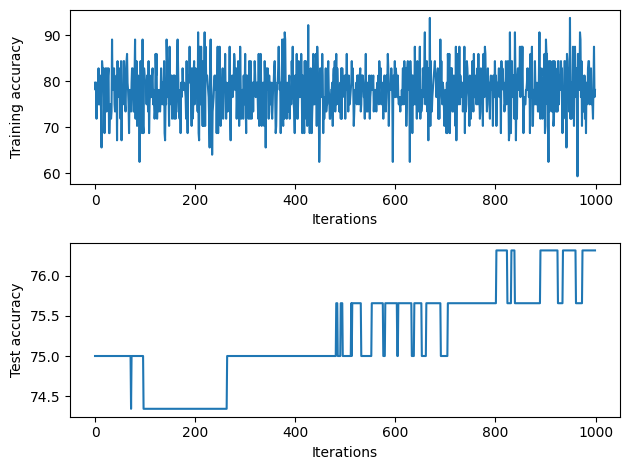

In [13]:
def plot_iter_vs_acc_graph(train_accuracies, test_accuracies):
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(nrows=2, ncols=1)

    ax = fig.add_subplot(gs[0, 0])
    ax.plot(train_accuracies)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Training accuracy")

    ax = fig.add_subplot(gs[1, 0])
    ax.plot(test_accuracies)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Test accuracy")

    fig.align_labels()
    plt.show()

plot_iter_vs_acc_graph(train_accuracies, test_accuracies)


In [14]:
torch.save(model.state_dict(), "modelsave.pth")
checkpoint = {
    "epoch": 100,
    "model_state": model.state_dict(),
    "optim_state": optimizer.state_dict()
}

torch.save(checkpoint, "checkpoint.pth")

In [ ]:
the_model = torch.load("modelsave.pth")
# print(the_model)

the_checkpoint = torch.load("checkpoint.pth")
# print(the_checkpoint)

# Part 2

In [15]:
def build_model(activation_function, initializer):

    # take the number of neurons equal to the number of features in the data
    input_size = X_data.shape[1]     # 7  
    hidden1_size = 64
    hidden2_size = 64
    num_classes = 2

    functions = {
        'ReLU': nn.ReLU(),
        'Leaky ReLU': nn.LeakyReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'Softmax': nn.Softmax(dim=0)
    }

    class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
            super().__init__()
            self.flatten = nn.Flatten()
            self.layer_stack = nn.Sequential(
                # hidden layer 1
                nn.Linear(input_size, hidden1_size),
                functions[activation_function],

                # hidden layer 2
                nn.Linear(hidden1_size, hidden2_size),
                functions[activation_function],
                
                # output layer
                nn.Linear(hidden2_size, num_classes)
            )

            
            # Initialize weights using Xavier initialization
            for layer in self.layer_stack:
                if isinstance(layer, nn.Linear):
                    if initializer == 'normal': nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                    elif initializer == 'xavier': nn.init.xavier_uniform_(layer.weight)
                    elif initializer == 'kaiming': nn.init.kaiming_normal_(layer.weight)
                    

        def forward(self, x):
            x = self.flatten(x)
            logits = self.layer_stack(x)
            return logits
        

    # observation: increasing the number of layers was causing overfitting and variance in the output.

    model = NeuralNetwork(input_size, hidden1_size, hidden2_size, num_classes).to(device)

    return model

In [16]:
def fit(model, loss_fn, optimizer, return_accuracies=False):

    optimizers = {
    'Adam': torch.optim.Adam(model.parameters(), lr=learning_rate),
    'ASGD': torch.optim.ASGD(model.parameters(), lr=learning_rate),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=learning_rate),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=learning_rate),
    'Adamax': torch.optim.Adamax(model.parameters(), lr=learning_rate)
    }

    optimizer_fn = optimizers[optimizer]

    for epoch in range(num_epochs):
        for data, targets in train_loader:
            data = data.cuda()
            targets = targets.cuda()

            preds = model(data)
            pred_labels = torch.argmax(preds, axis=1)
            loss = loss_fn(preds, targets)
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

            train_accuracies.append(
                100 * torch.mean((pred_labels == targets).float()).item()
            )

            # Test set
            X, y = next(iter(test_loader))
            X = X.cuda()
            y = y.cuda()
            pred_labels = torch.argmax(model(X), axis=1)
            test_accuracies.append(
                100 * torch.mean((pred_labels == y).float()).item()
            )

    return (train_accuracies, test_accuracies) if return_accuracies == True else (max(train_accuracies), max(test_accuracies))


batch_size = 64         # can use 128 too, since we are utilizing the GPU (cuda device)
num_epochs = 100
learning_rate = 0.0001
train_accuracies, test_accuracies = [], []

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))

print(f"\nEpochs: {num_epochs}")

print(f"\ntrain batch size: {batch_size}")
print(f"number of batches: {len(train_loader)}")

print(f"\ntrain batch size: {len(test_data.tensors[0])}")
print(f"number of batches: {len(test_loader)}")

# choose the loss function
loss_fn = nn.CrossEntropyLoss()


print(f"\n======================================         Modifying activation functions         ======================================\n")
# different activation functions tried with 'normal' weight initialization and the 'Adam' optimizer
print(f"Using 'normal' weight initialization and the 'Adam' optimizer\n")
optimizer = 'Adam'
activation_functions = ['ReLU', 'Leaky ReLU', 'Sigmoid', 'Tanh', 'Softmax']
for function in activation_functions:
    model = build_model(function, 'normal')
    result = fit(model, loss_fn, optimizer)
    print(f"Max training accuracy with {function} activation function: {result[0]}")
    print(f"Max testing accuracy with {function} activation function: {result[1]}\n")


print(f"\n======================================         Modifying weight initializers         ======================================\n")
# different initializers tried with 'ReLU' activation function and the 'Adam' optimizer
print(f"Using 'ReLU' activation function and the 'Adam' optimizer\n")
optimizer = 'Adam'
initializers = ['normal', 'kaiming', 'xavier']
for initializer in initializers:
    model = build_model('ReLU', initializer)
    result = fit(model, loss_fn, optimizer)
    print(f"Max training accuracy with {initializer} weight initializer: {result[0]}")
    print(f"Max testing accuracy with {initializer} weight initializer: {result[1]}\n")


print(f"\n======================================         Modifying optimizers         ======================================\n")
# 'ReLU' models with 'normal' weight initialization, tried with different optimizers
print(f"Using 'normal' weight initialization and the 'ReLU' activation function\n")
relu_model = build_model('ReLU', 'normal')
optimizers = ['Adam', 'NAdam', 'RAdam', 'ASGD', 'Adamax']
for optimizer in optimizers:
    result = fit(relu_model, loss_fn, optimizer)
    print(f"Max training accuracy with {optimizer} optimizer: {result[0]}")
    print(f"Max testing accuracy with {optimizer} optimizer: {result[1]}\n")



Epochs: 100

train batch size: 64
number of batches: 10

train batch size: 152
number of batches: 1

======================================         Modifying activation functions         ======================================

Using 'normal' weight initialization and the 'Adam' optimizer

Max training accuracy with ReLU activation function: 90.625
Max testing accuracy with ReLU activation function: 76.97368264198303

Max training accuracy with Leaky ReLU activation function: 92.1875
Max testing accuracy with Leaky ReLU activation function: 76.97368264198303

Max training accuracy with Sigmoid activation function: 92.1875
Max testing accuracy with Sigmoid activation function: 76.97368264198303

Max training accuracy with Tanh activation function: 93.75
Max testing accuracy with Tanh activation function: 76.97368264198303

Max training accuracy with Softmax activation function: 93.75
Max testing accuracy with Softmax activation function: 76.97368264198303


=============================

Based on the results above, we can see that the models trained with 'ReLU' activation function, 'normal' weight initialization, and any one of the ['NAdam', 'RAdam', 'ASGD', 'Adamax'] optimizer yield the best results. We will proceed with the 'RAdam' optimizer.

Max training accuracy with best model: 96.875
Max testing accuracy with best model: 76.97368264198303



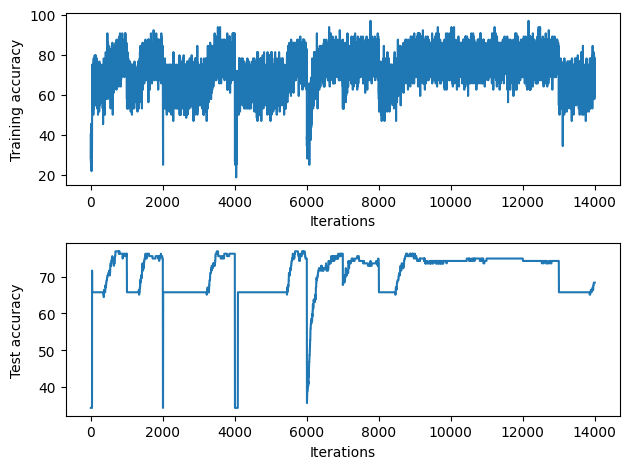

In [17]:
best_model = build_model('ReLU', 'normal')
best_fit = fit(best_model, loss_fn, optimizer = 'RAdam', return_accuracies=True)

train_accuracies, test_accuracies = best_fit
print(f"Max training accuracy with best model: {max(train_accuracies)}")
print(f"Max testing accuracy with best model: {max(test_accuracies)}\n")

# plot
plot_iter_vs_acc_graph(train_accuracies, test_accuracies)

Now, we will try some techniques and see how they impact the performance of our model

## Dropout

Max training accuracy with best model: 96.875
Max testing accuracy with best model: 76.97368264198303



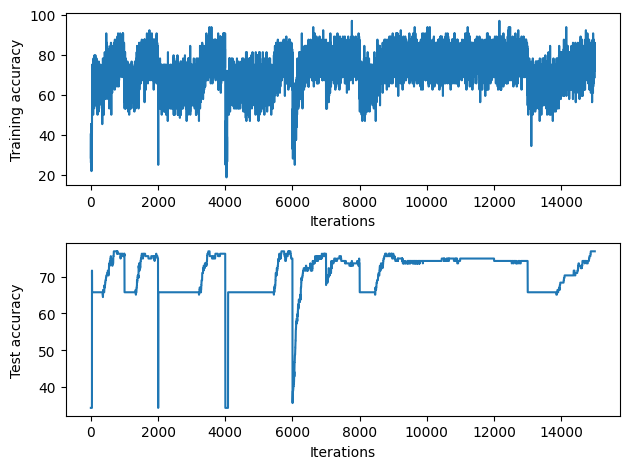

In [18]:
# builing an ANN with dropout layers

def build_model(activation_function, initializer):

    # take the number of neurons equal to the number of features in the data
    input_size = X_data.shape[1]     # 7  
    hidden1_size = 32
    hidden2_size = 32
    num_classes = 2

    functions = {
        'ReLU': nn.ReLU(),
        'Leaky ReLU': nn.LeakyReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'Softmax': nn.Softmax(dim=0)
    }

    class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
            super().__init__()
            self.flatten = nn.Flatten()
            self.layer_stack = nn.Sequential(
                # hidden layer 1
                nn.Linear(input_size, hidden1_size),
                functions[activation_function],
                nn.Dropout(0.2),

                # hidden layer 2
                nn.Linear(hidden1_size, hidden2_size),
                functions[activation_function],
                nn.Dropout(0.2),
                
                # output layer
                nn.Linear(hidden2_size, num_classes)
            )

            
            # Initialize weights using Xavier initialization
            for layer in self.layer_stack:
                if isinstance(layer, nn.Linear):
                    if initializer == 'normal': nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                    elif initializer == 'xavier': nn.init.xavier_uniform_(layer.weight)
                    elif initializer == 'kaiming': nn.init.kaiming_normal_(layer.weight)
                    

        def forward(self, x):
            x = self.flatten(x)
            logits = self.layer_stack(x)
            return logits
        

    # observation: increasing the number of layers was causing overfitting and variance in the output.

    model = NeuralNetwork(input_size, hidden1_size, hidden2_size, num_classes).to(device)

    return model

model_with_dropout = build_model('ReLU', 'normal')
model_with_dropout_fit = fit(best_model, loss_fn, optimizer = 'RAdam', return_accuracies=True)

train_accuracies, test_accuracies = model_with_dropout_fit
print(f"Max training accuracy with best model: {max(train_accuracies)}")
print(f"Max testing accuracy with best model: {max(test_accuracies)}\n")

# plot
plot_iter_vs_acc_graph(train_accuracies, test_accuracies)

## Learning Rate Scheduler

Max training accuracy with best model: 100.0
Max testing accuracy with best model: 76.97368264198303



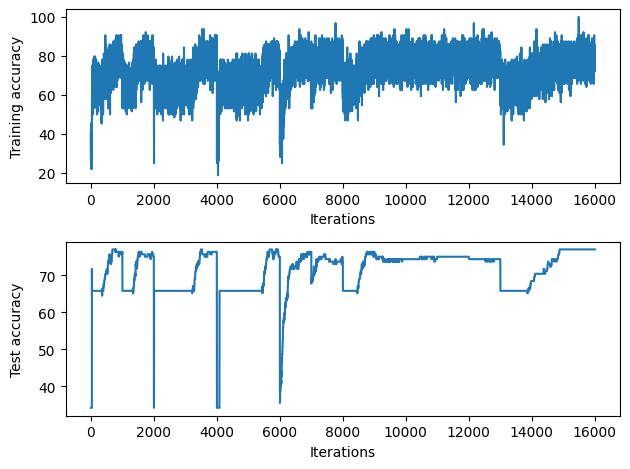

In [19]:
def lrr_fit(model, loss_fn, optimizer, return_accuracies=False):

    optimizers = {
    'Adam': torch.optim.Adam(model.parameters(), lr=learning_rate),
    'ASGD': torch.optim.ASGD(model.parameters(), lr=learning_rate),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=learning_rate),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=learning_rate),
    'Adamax': torch.optim.Adamax(model.parameters(), lr=learning_rate)
    }

    optimizer_fn = optimizers[optimizer]

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fn, factor = 0.1, patience=5, verbose = True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fn, step_size=100, gamma=0.1)
    # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer_fn, start_factor=0.5, total_iters=4)

    for epoch in range(num_epochs):
        for data, targets in train_loader:
            data = data.cuda()
            targets = targets.cuda()

            preds = model(data)
            pred_labels = torch.argmax(preds, axis=1)
            loss = loss_fn(preds, targets)
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()
            scheduler.step()

            train_accuracies.append(
                100 * torch.mean((pred_labels == targets).float()).item()
            )

            # Test set
            X, y = next(iter(test_loader))
            X = X.cuda()
            y = y.cuda()
            pred_labels = torch.argmax(model(X), axis=1)
            test_accuracies.append(
                100 * torch.mean((pred_labels == y).float()).item()
            )

    return (train_accuracies, test_accuracies) if return_accuracies == True else (max(train_accuracies), max(test_accuracies))

model_with_lrr_scheduler = build_model('ReLU', 'normal')
model_with_lrr_scheduler_fit = lrr_fit(best_model, loss_fn, optimizer = 'RAdam', return_accuracies=True)

train_accuracies, test_accuracies = model_with_dropout_fit
print(f"Max training accuracy with best model: {max(train_accuracies)}")
print(f"Max testing accuracy with best model: {max(test_accuracies)}\n")

# plot
plot_iter_vs_acc_graph(train_accuracies, test_accuracies)

## Earlystopping

Max training accuracy with best model: 100.0
Max testing accuracy with best model: 76.97368264198303



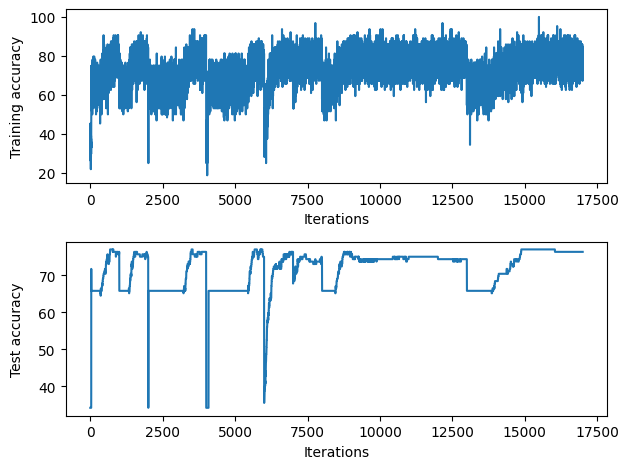

In [20]:
def early_stopping_fit(model, loss_fn, optimizer, return_accuracies=False):

    optimizers = {
    'Adam': torch.optim.Adam(model.parameters(), lr=learning_rate),
    'ASGD': torch.optim.ASGD(model.parameters(), lr=learning_rate),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=learning_rate),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=learning_rate),
    'Adamax': torch.optim.Adamax(model.parameters(), lr=learning_rate)
    }

    optimizer_fn = optimizers[optimizer]

    # define early-stopping parameters
    patience = 5
    best_loss = float('inf')
    best_epoch = 0
    no_improvement_count = 0

    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        for data, targets in train_loader:
            data = data.cuda()
            targets = targets.cuda()

            preds = model(data)
            pred_labels = torch.argmax(preds, axis=1)
            loss = loss_fn(preds, targets)
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

            train_accuracies.append(
                100 * torch.mean((pred_labels == targets).float()).item()
            )

            # Test set
            X, y = next(iter(test_loader))
            X = X.cuda()
            y = y.cuda()
            pred_labels = torch.argmax(model(X), axis=1)
            test_accuracies.append(
                100 * torch.mean((pred_labels == y).float()).item()
            )

        model.eval()
        with torch.no_grad():
            test_loss = 0
            for X, y in test_loader:
                X = X.cuda()
                y = y.cuda()
                preds = model(X)
                test_loss += loss_fn(preds, y).item()
                pred_labels = torch.argmax(preds, axis=1)
                test_accuracies.append(
                    100 * torch.mean((pred_labels == y).float()).item()
                )
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                break

    return (train_accuracies, test_accuracies) if return_accuracies == True else (max(train_accuracies), max(test_accuracies))

model_with_lrr_scheduler = build_model('ReLU', 'normal')
model_with_lrr_scheduler_fit = lrr_fit(best_model, loss_fn, optimizer = 'RAdam', return_accuracies=True)

train_accuracies, test_accuracies = model_with_dropout_fit
print(f"Max training accuracy with best model: {max(train_accuracies)}")
print(f"Max testing accuracy with best model: {max(test_accuracies)}\n")

# plot
plot_iter_vs_acc_graph(train_accuracies, test_accuracies)

## k-fold

Accuracy with k-fold: 75.82441091537476


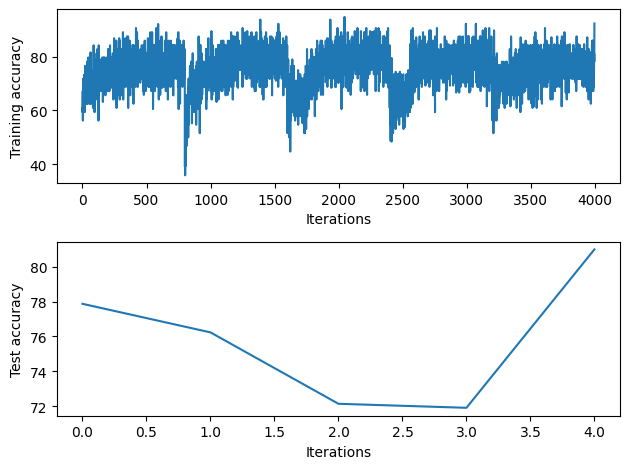

In [23]:
# define the number of folds
k = 5

# split the data into k folds
kfold = KFold(n_splits=k, shuffle=True)

# initialize lists to store the training and test accuracies for each fold
train_accuracies = list()
test_accuracies = list()


# iterate through the folds
for fold, (train_idx, test_idx) in enumerate(kfold.split(X_train)):

    # select the data for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_test_fold, y_test_fold = X_train[test_idx], y_train[test_idx]

    # create the data loaders for this fold
    train_data = TensorDataset(X_train_fold, y_train_fold)
    test_data = TensorDataset(X_test_fold, y_test_fold)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))

    # train the model for this fold
    model = NeuralNetwork(input_size, hidden1_size, hidden2_size, num_classes)
    model.cuda()

    # set the loss and optimizer functions
    loss_fn = nn.CrossEntropyLoss()
    optimizer_fn = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # fit the model
    for epoch in range(num_epochs):
        for data, targets in train_loader:
            data = data.cuda()
            targets = targets.cuda()
            preds = model(data)
            pred_labels = torch.argmax(preds, axis=1)
            loss = loss_fn(preds, targets)
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()
            train_accuracies.append(
                100 * torch.mean((pred_labels == targets).float()).item()
            )

    # fit the model on the test set for this fold
    X_test_fold = X_test_fold.cuda()
    y_test_fold = y_test_fold.cuda()
    pred_labels = torch.argmax(model(X_test_fold), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y_test_fold).float()).item()
    )

# compute the mean test accuracy over all folds
mean_test_accuracy = np.mean(test_accuracies)

print(f"Accuracy with k-fold: {mean_test_accuracy}")

# plot
plot_iter_vs_acc_graph(train_accuracies, test_accuracies)


As we can see, utilizing the k-fold cross-validation does not help much in improving the accuracy.

## References:

https://pytorch.org/tutorials/index.html

https://pytorch.org/docs/stable/optim.html

https://appsilon.com/pytorch-neural-network-tutorial/

https://stackoverflow.com/

https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9